# PRODUCTION PLANNING FUNCTION FOR STATIC INITIAL DATASET

In [1]:
#importing libraries
import pandas as pd
import openpyxl as xl
import json

def data_excel_json(excel_sheet):
    """ convert excel into json """
    data_excel = xl.load_workbook(excel_sheet)
    data = {}
    sheet_name = data_excel.sheetnames
    for sheet in sheet_name:
        wb_sheet = data_excel[sheet]
        cell_values = wb_sheet.values
        df =  pd.DataFrame(cell_values, columns=next(cell_values))
        df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x : x.strip())
        df.index = df.iloc[:, 0]
        df.drop(columns = df.columns[0], inplace=True)
        data[sheet] = df.T.to_dict()
    return data

def json_to_df(json_data):
    """ convert json into excel """
    dict_data = {}
    for key in json_data.keys():
        dict_data[key] = pd.DataFrame(json_data.get(key)).T
    return dict_data


# DEPLOYING GENETIC ALGORITHMS

In [2]:
# importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chart_studio.plotly as py
import plotly.figure_factory as ff
import datetime
import time
import copy


def json_to_df(json_data):
    """ convert json into excel """
    dict_data = {}
    for key in json_data.keys():
        dict_data[key] = pd.DataFrame(json_data.get(key)).T

    return dict_data



def generate_initial_population(population_size, num_gene):

    """ generate initial population for Genetic Algorithm """

    best_list, best_obj = [], []
    population_list = []
    makespan_record = []
    for i in range(population_size):
        nxm_random_num = list(np.random.permutation(num_gene)) # generate a random permutation of 0 to num_job*num_mc-1
        population_list.append(nxm_random_num) # add to the population_list
        for j in range(num_gene):
            population_list[i][j] = population_list[i][j] % num_job # convert to job number format, every job appears m times

    return population_list



def job_schedule(data_dict, population_size = 30, crossover_rate = 0.8, mutation_rate = 0.2, mutation_selection_rate = 0.2, num_iteration = 2000):

    """ initialize genetic algorithm parameters and read data """
    data_json  = json_to_df(data_dict)
    machine_sequence_tmp = data_json['Machines Sequence']
    process_time_tmp = data_json['Processing Time']

    df_shape = process_time_tmp.shape
    num_machines = df_shape[1] # number of machines
    num_job = df_shape[0] # number of jobs
    num_gene = num_machines * num_job # number of genes in a chromosome
    num_mutation_jobs = round(num_gene * mutation_selection_rate)

    process_time = [list(map(int, process_time_tmp.iloc[i])) for i in range(num_job)]
    machine_sequence = [list(map(int, machine_sequence_tmp.iloc[i])) for i in range(num_job)]
    
    #start_time = time.time()

    Tbest = 999999999999999

    best_list, best_obj = [], []
    population_list = []
    makespan_record = []

    for i in range(population_size):
        nxm_random_num = list(np.random.permutation(num_gene)) # generate a random permutation of 0 to num_job*num_mc-1
        population_list.append(nxm_random_num) # add to the population_list
        for j in range(num_gene):
            population_list[i][j] = population_list[i][j] % num_job # convert to job number format, every job appears m times
    #population_list = generate_initial_population(population_size=population_size, num_gene=num_gene)

    for iteration in range(num_iteration):
        Tbest_now = 99999999999

        """ Two Point Cross-Over """
        parent_list = copy.deepcopy(population_list)
        offspring_list = copy.deepcopy(population_list) # generate a random sequence to select the parent chromosome to crossover
        pop_random_size = list(np.random.permutation(population_size))

        for size in range(int(population_size/2)):
            crossover_prob = np.random.rand()
            if crossover_rate >= crossover_prob:
                parent_1 = population_list[pop_random_size[2*size]][:]
                parent_2 = population_list[pop_random_size[2*size+1]][:]

                child_1 = parent_1[:]
                child_2 = parent_2[:]
                cutpoint = list(np.random.choice(num_gene, 2, replace=False))
                cutpoint.sort()

                child_1[cutpoint[0]:cutpoint[1]] = parent_2[cutpoint[0]:cutpoint[1]]
                child_2[cutpoint[0]:cutpoint[1]] = parent_1[cutpoint[0]:cutpoint[1]]
                offspring_list[pop_random_size[2*size]] = child_1[:]
                offspring_list[pop_random_size[2*size+1]] = child_2[:]


        for pop in range(population_size):

            """ Repairment """
            job_count = {}
            larger, less = [], [] # 'larger' record jobs appear in the chromosome more than pop times, and 'less' records less than pop times.
            for job in range(num_job):
                if job in offspring_list[pop]:
                    count = offspring_list[pop].count(job)
                    pos = offspring_list[pop].index(job)
                    job_count[job] = [count, pos] # store the above two values to the job_count dictionary
                else:
                    count = 0
                    job_count[job] = [count, 0]

                if count > num_machines:
                    larger.append(job)
                elif count < num_machines:
                    less.append(job)
                    
            for large in range(len(larger)):
                change_job = larger[large]
                while job_count[change_job][0] > num_machines:
                    for les in range(len(less)):
                        if job_count[less[les]][0] < num_machines:                    
                            offspring_list[pop][job_count[change_job][1]] = less[les]
                            job_count[change_job][1] = offspring_list[pop].index(change_job)
                            job_count[change_job][0] = job_count[change_job][0]-1
                            job_count[less[les]][0] = job_count[less[les]][0]+1                    
                        if job_count[change_job][0] == num_machines:
                            break     
    

        
        for off_spring in range(len(offspring_list)):

            """ Mutations """
            mutation_prob = np.random.rand()
            if mutation_rate >= mutation_prob:
                m_change = list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # chooses the position to mutation
                t_value_last = offspring_list[off_spring][m_change[0]] # save the value which is on the first mutation position
                for i in range(num_mutation_jobs-1):
                    offspring_list[off_spring][m_change[i]] = offspring_list[off_spring][m_change[i+1]] # displacement
                # move the value of the first mutation position to the last mutation position
                offspring_list[off_spring][m_change[num_mutation_jobs-1]] = t_value_last 



        """ fitness value (calculate makespan) """
        total_chromosome = copy.deepcopy(parent_list) + copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
        chrom_fitness, chrom_fit = [], []
        total_fitness = 0
        for pop_size in range(population_size*2):
            j_keys = [j for j in range(num_job)]
            key_count = {key:0 for key in j_keys}
            j_count = {key:0 for key in j_keys}
            m_keys = [j+1 for j in range(num_machines)]
            m_count = {key:0 for key in m_keys}
            
            for i in total_chromosome[pop_size]:
                gen_t = int(process_time[i][key_count[i]])
                gen_m = int(machine_sequence[i][key_count[i]])
                j_count[i] = j_count[i] + gen_t
                m_count[gen_m] = m_count[gen_m] + gen_t
                
                if m_count[gen_m] < j_count[i]:
                    m_count[gen_m] = j_count[i]
                elif m_count[gen_m] > j_count[i]:
                    j_count[i] = m_count[gen_m]
                
                key_count[i] = key_count[i] + 1
        
            makespan = max(j_count.values())
            chrom_fitness.append(1/makespan)
            chrom_fit.append(makespan)
            total_fitness = total_fitness + chrom_fitness[pop_size]
        

        """ Selection (roulette wheel approach) """
        pk, qk = [], []
        
        for size in range(population_size * 2):
            pk.append(chrom_fitness[size] / total_fitness)
        for size in range(population_size * 2):
            cumulative = 0

            for j in range(0, size+1):
                cumulative = cumulative + pk[j]
            qk.append(cumulative)
        
        selection_rand = [np.random.rand() for i in range(population_size)]
        
        for pop_size in range(population_size):
            if selection_rand[pop_size] <= qk[0]:
                population_list[pop_size] = copy.deepcopy(total_chromosome[0])
            else:
                for j in range(0, population_size * 2-1):
                    if selection_rand[pop_size] > qk[j] and selection_rand[pop_size] <= qk[j+1]:
                        population_list[pop_size] = copy.deepcopy(total_chromosome[j+1])
                        break


        """ comparison """
        for pop_size in range(population_size * 2):
            if chrom_fit[pop_size] < Tbest_now:
                Tbest_now = chrom_fit[pop_size]
                sequence_now = copy.deepcopy(total_chromosome[pop_size])
        if Tbest_now <= Tbest:
            Tbest = Tbest_now
            sequence_best = copy.deepcopy(sequence_now)
            
        makespan_record.append(Tbest)

    """ Results - Makespan """

    print("optimal sequence", sequence_best)
    print("optimal value:%f"%Tbest)
    print("\n")
    #print('the elapsed time:%s'% (time.time() - start_time))

    #%matplotlib inline
    plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
    plt.ylabel('makespan', fontsize=15)
    plt.xlabel('generation', fontsize=15)
    plt.show()


    """ plot gantt chart """

    m_keys = [j+1 for j in range(num_machines)]
    j_keys = [j for j in range(num_job)]
    key_count = {key:0 for key in j_keys}
    j_count = {key:0 for key in j_keys}
    m_count = {key:0 for key in m_keys}
    j_record = {}
    for i in sequence_best:
        gen_t = int(process_time[i][key_count[i]])
        gen_m = int(machine_sequence[i][key_count[i]])
        j_count[i] = j_count[i] + gen_t
        m_count[gen_m] = m_count[gen_m] + gen_t

        if m_count[gen_m] < j_count[i]:
            m_count[gen_m] = j_count[i]
        elif m_count[gen_m] > j_count[i]:
            j_count[i] = m_count[gen_m]

        start_time = str(datetime.timedelta(seconds = j_count[i] - process_time[i][key_count[i]])) # convert seconds to hours, minutes and seconds
        end_time = str(datetime.timedelta(seconds = j_count[i]))

        j_record[(i, gen_m)] = [start_time, end_time]

        key_count[i] = key_count[i] + 1


    df = []
    for m in m_keys:
        for j in j_keys:
            df.append(dict(Task='Machine %s'%(m), Start='2020-02-01 %s'%(str(j_record[(j,m)][0])), \
                            Finish='2020-02-01 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
    
    df_ = pd.DataFrame(df)
    df_.Start = pd.to_datetime(df_['Start'])
    df_.Finish = pd.to_datetime(df_['Finish'])
    start = df_.Start.min()
    end = df_.Finish.max()

    df_.Start = df_.Start.apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%S'))
    df_.Finish = df_.Finish.apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%S'))
    data = df_.to_dict('record')

    final_data ={
        'start':start.strftime('%Y-%m-%dT%H:%M:%S'),
        'end':end.strftime('%Y-%m-%dT%H:%M:%S'),
        'data':data}
        
    fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
    fig.show()
    #iplot(fig, filename='GA_job_shop_scheduling')
    return final_data, df


# JOB-SHOP SCHEDULING

optimal sequence [7, 4, 0, 0, 7, 1, 5, 1, 1, 4, 6, 6, 3, 3, 4, 1, 6, 8, 3, 4, 4, 6, 5, 8, 6, 7, 4, 6, 6, 7, 7, 1, 6, 8, 1, 7, 2, 4, 8, 8, 6, 4, 0, 3, 5, 3, 5, 8, 6, 9, 1, 2, 9, 0, 9, 3, 5, 8, 1, 0, 9, 3, 0, 2, 4, 5, 2, 9, 2, 8, 4, 8, 7, 1, 9, 9, 3, 7, 9, 3, 2, 0, 5, 2, 1, 3, 2, 7, 0, 2, 5, 8, 7, 9, 9, 2, 0, 5, 5, 0]
optimal value:1154.000000




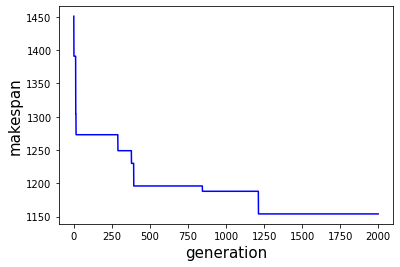

/var/folders/d1/0b_ckbv94b76520jr7j7ydzw0000gn/T/ipykernel_3334/3057518626.py:265: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  data = df_.to_dict('record')


In [3]:
data = data_excel_json('data/JSP_dataset.xlsx')
schedule = job_schedule(data_dict=data)


# JSON to draw gantt chart

In [4]:
schedule[0]

{'start': '2020-02-01T00:00:00',
 'end': '2020-02-01T00:19:14',
 'data': [{'Task': 'Machine 1',
   'Start': '2020-02-01T00:00:00',
   'Finish': '2020-02-01T00:00:29',
   'Resource': 'Job 1'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:01:57',
   'Finish': '2020-02-01T00:02:40',
   'Resource': 'Job 2'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:08:51',
   'Finish': '2020-02-01T00:10:16',
   'Resource': 'Job 3'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:05:45',
   'Finish': '2020-02-01T00:06:56',
   'Resource': 'Job 4'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:02:40',
   'Finish': '2020-02-01T00:02:46',
   'Resource': 'Job 5'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:13:26',
   'Finish': '2020-02-01T00:14:13',
   'Resource': 'Job 6'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:02:46',
   'Finish': '2020-02-01T00:03:23',
   'Resource': 'Job 7'},
  {'Task': 'Machine 1',
   'Start': '2020-02-01T00:00:31',
   'Finish': '2020-02-01T00:0

In [5]:
import chart_studio.plotly as py
import plotly.figure_factory as ff

df = schedule[1]
fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
fig.show()